## Traininig of the High Level Feature classifier with Pytorch and Petastorm

**PyTorch and Petastorm, HLF classifier** This notebooks trains a dense neural network for the particle classifier using High Level Features. It uses Pytorch on a single node. Petastorm is used to read the data and pass it to PyTorch.

Credits: this notebook is taken with permission from the work: 
- [Machine Learning Pipelines with Modern Big Data Tools for High Energy Physics Comput Softw Big Sci 4, 8 (2020)](https://rdcu.be/b4Wk9)  
- Code and data at:https://github.com/cerndb/SparkDLTrigger
- The model is a classifier implemented as a DNN
  - Model input: 14 "high level features", described in [ Topology classification with deep learning to improve real-time event selection at the LHC](https://link.springer.com/epdf/10.1007/s41781-019-0028-1?author_access_token=eTrqfrCuFIP2vF4nDLnFfPe4RwlQNchNByi7wbcMAY7NPT1w8XxcX1ECT83E92HWx9dJzh9T9_y5Vfi9oc80ZXe7hp7PAj21GjdEF2hlNWXYAkFiNn--k5gFtNRj6avm0UukUt9M9hAH_j4UR7eR-g%3D%3D)
  - Model output: 3 classes, "W + jet", "QCD", "$t\bar{t}$"

## Load train and test datasets using Petastorm

In [1]:
# Download the datasets from 
# https://github.com/cerndb/SparkDLTrigger/tree/master/Data
#
# For CERN users, data is already available on EOS
PATH = "file:///eos/project/s/sparkdltrigger/public/"

file_train_dataset = PATH + "trainUndersampled_HLF_features.parquet"
file_test_dataset = PATH + "testUndersampled_HLF_features.parquet"


# Note, PATH needs to be prefixed by the fileystem type as in:
# "file://<full_path>_on_filesystem/Parquet_folder/"
# "hdfs://<full_path_on_hdfs>/Parquet_folder/"


In [ ]:
# Install petastorm
!pip install petastorm

In [3]:
# We use the petastorm libary to load and feed the training and test data in Parquet format
# It makes use TensorFLow tf.data.dataset

import petastorm
from petastorm import make_batch_reader
from petastorm.pytorch import DataLoader, BatchedDataLoader

petastorm.__version__


'0.12.1'

## Create PyTorch model

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

torch.__version__

'2.0.0a0'

In [5]:
torch.cuda.is_available()

True

In [6]:
class Net(nn.Module):
    def __init__(self, nh_1, nh_2, nh_3):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(14, nh_1)
        self.fc2 = nn.Linear(nh_1, nh_2)
        self.fc3 = nn.Linear(nh_2, nh_3)
        self.fc4 = nn.Linear(nh_3, 3)
        
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        output = nn.functional.softmax(self.fc4(x), dim=1)
        return output

def create_model(nh_1, nh_2, nh_3):
    model = Net(nh_1, nh_2, nh_3)
    return model


## Train the model

In [7]:
# handles the test/validation dataset
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    num_samples = 0
    with torch.no_grad():
        for values in test_loader:
            data = values['HLF_input'].to(torch.float32).to(device)
            target = values['encoded_label'].to(torch.float32).to(device)
            output = model(data)
            test_loss += nn.functional.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            target = target.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            num_samples += len(data)

    test_loss /= num_samples
    test_accuracy = 100. * correct / num_samples

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, num_samples, test_accuracy))
    return(test_loss, test_accuracy)


In [8]:
# handles training of one eopch
def train_epoch(model, device, train_loader, optimizer, epoch):
    log_interval = 10000
    model.train()
    correct = 0
    num_samples = 0
    for batch_idx, values in enumerate(train_loader):
        data = values['HLF_input'].to(torch.float32).to(device)
        target = values['encoded_label'].to(torch.float32).to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.functional.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        # metrics
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        target = target.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        num_samples += len(data)
        #
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), loss.item()))

    train_loss = loss.item()
    train_accuracy = 100. * correct / num_samples
    print('\nTrain set: Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        train_loss, correct, num_samples, train_accuracy))

    return(train_loss, train_accuracy)

In [9]:
def train_loop(model, epochs, optimizer, device):
    hist = {}
    hist['loss'] = []
    hist['accuracy'] = []
    hist['val_loss'] = []
    hist['val_accuracy'] = []
    for epoch in range(1, epochs + 1):
        train_loss, train_accuracy = train_epoch(model, device, train_loader, optimizer, epoch)
        val_loss, val_accuracy = test(model, device, test_loader)
        hist['loss'] += [train_loss]
        hist['accuracy'] += [train_accuracy]
        hist['val_loss'] += [val_loss]
        hist['val_accuracy'] += [val_accuracy]
    return(hist)


In [11]:
# Setup and run the training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda")

model = create_model(50,20,10).to(device)
optimizer = optim.Adam(model.parameters())
epochs = 5

train_batch_size = 128
test_batch_size = 10240
torch.manual_seed(42)

# Map train and test data using Petastorm's BatchedDataLoader and Pytorch's make_batch_reader
# This work both with DataLoader and BatchedDataLoader
with BatchedDataLoader(make_batch_reader(file_test_dataset, num_epochs = 1, shuffle_row_groups = False), batch_size = test_batch_size) as test_loader:
    with BatchedDataLoader(make_batch_reader(file_train_dataset, num_epochs = 1, shuffle_row_groups = True), batch_size = train_batch_size) as train_loader:
        %time hist = train_loop(model, epochs, optimizer, device) # run the training loop and collects metrics


Train Epoch: 1 [0]	Loss: 1.095839
Train Epoch: 1 [1280000]	Loss: 0.649432
Train Epoch: 1 [2560000]	Loss: 0.650366

Train set: Loss: 0.6421, Accuracy: 3031053/3426083 (88%)



Test set: Average loss: 0.6546, Accuracy: 765669/856090 (89%)

Train Epoch: 2 [0]	Loss: 0.608500
Train Epoch: 2 [1280000]	Loss: 0.602160
Train Epoch: 2 [2560000]	Loss: 0.649343



Train set: Loss: 0.6847, Accuracy: 3086542/3426083 (90%)



Test set: Average loss: 0.6449, Accuracy: 774206/856090 (90%)

Train Epoch: 3 [0]	Loss: 0.631313
Train Epoch: 3 [1280000]	Loss: 0.664077
Train Epoch: 3 [2560000]	Loss: 0.593584



Train set: Loss: 0.6208, Accuracy: 3101779/3426083 (91%)



Test set: Average loss: 0.6425, Accuracy: 776438/856090 (91%)

Train Epoch: 4 [0]	Loss: 0.674086
Train Epoch: 4 [1280000]	Loss: 0.639654
Train Epoch: 4 [2560000]	Loss: 0.610834



Train set: Loss: 0.6121, Accuracy: 3109411/3426083 (91%)



Test set: Average loss: 0.6423, Accuracy: 776531/856090 (91%)

Train Epoch: 5 [0]	Loss: 0.616399
Train Epoch: 5 [1280000]	Loss: 0.633801
Train Epoch: 5 [2560000]	Loss: 0.617487



Train set: Loss: 0.6720, Accuracy: 3114906/3426083 (91%)

Test set: Average loss: 0.6407, Accuracy: 777935/856090 (91%)

CPU times: user 27min 52s, sys: 42min 17s, total: 1h 10min 10s
Wall time: 48min 30s


## Performance metrics

<IPython.core.display.Javascript object>


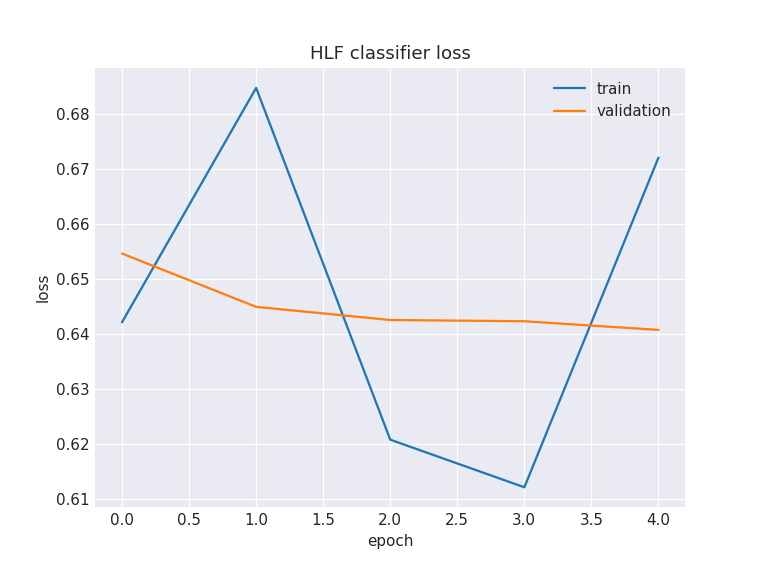

In [12]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
# Graph with loss vs. epoch

plt.figure()
plt.plot(hist['loss'], label='train')
plt.plot(hist['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title("HLF classifier loss")
plt.show()

<IPython.core.display.Javascript object>


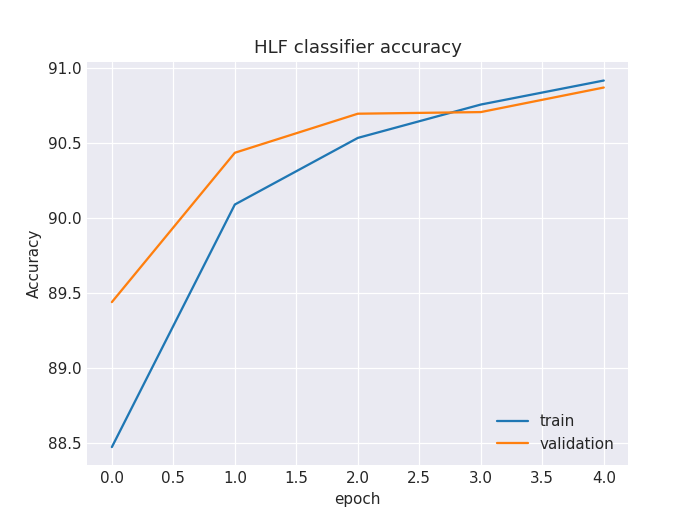

In [13]:
# Graph with accuracy vs. epoch
%matplotlib notebook
plt.figure()
plt.plot(hist['accuracy'], label='train')
plt.plot(hist['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title("HLF classifier accuracy")
plt.show()

## Confusion Matrix

In [16]:
import numpy as np

with DataLoader(make_batch_reader(file_test_dataset, num_epochs = 1, workers_count=1, shuffle_row_groups = False, shuffle_rows=False), batch_size = test_batch_size) as test_loader:
    with torch.no_grad():
        # predicted values
        y_pred = np.concatenate([model(data['HLF_input'].to(torch.float32).to(device)).cpu().numpy() for data in test_loader])

with DataLoader(make_batch_reader(file_test_dataset, num_epochs = 1, workers_count=1, shuffle_row_groups = False, shuffle_rows=False), batch_size = test_batch_size) as test_loader:
    with torch.no_grad():
        # extract test labels
        y_true = np.concatenate([data['encoded_label'].to(torch.float32).cpu().numpy() for data in test_loader])

/eos/user/c/canali/.local/lib/python3.9/site-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
  self._filesystem = pyarrow.localfs
/eos/user/c/canali/.local/lib/python3.9/site-packages/petastorm/etl/dataset_metadata.py:402: FutureWarning: Passing 'use_legacy_dataset=True' to get the legacy behaviour is deprecated as of pyarrow 11.0.0, and the legacy implementation will be removed in a future version. The legacy behaviour was still chosen because a deprecated 'pyarrow.filesystem' filesystem was specified (use the filesystems from pyarrow.fs instead).
  dataset = pq.ParquetDataset(path_or_paths, filesystem=fs, validate_schema=False, metadata_nthreads=10)
/eos/user/c/canali/.local/lib/python3.9/site-packages/petastorm/etl/dataset_metadata.py:402: FutureWarning: Specifying the 'metadata_nthreads' argument is deprecated as of pyarrow 8.0.0, and the argument will be removed in a future version
  datase

In [17]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9087


<IPython.core.display.Javascript object>


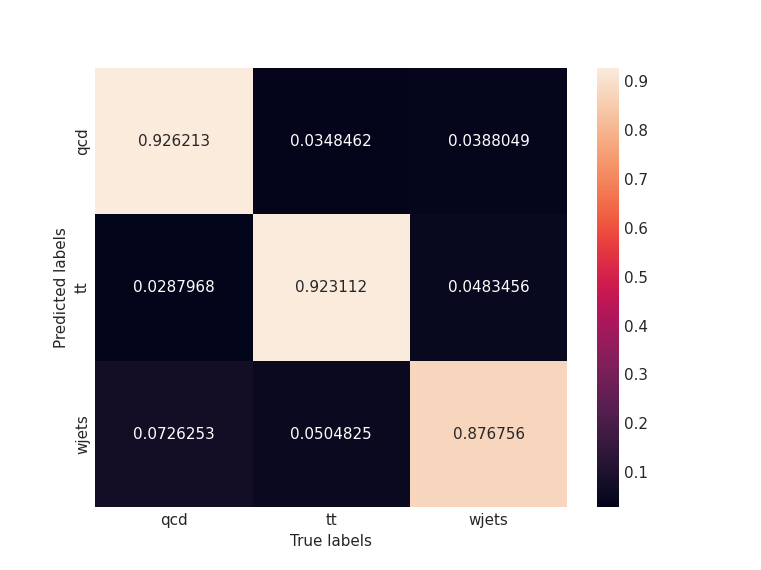

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## ROC and AUC

In [19]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [20]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.9830547898173296, 1: 0.9808302460953595, 2: 0.9758440798308753}

<IPython.core.display.Javascript object>


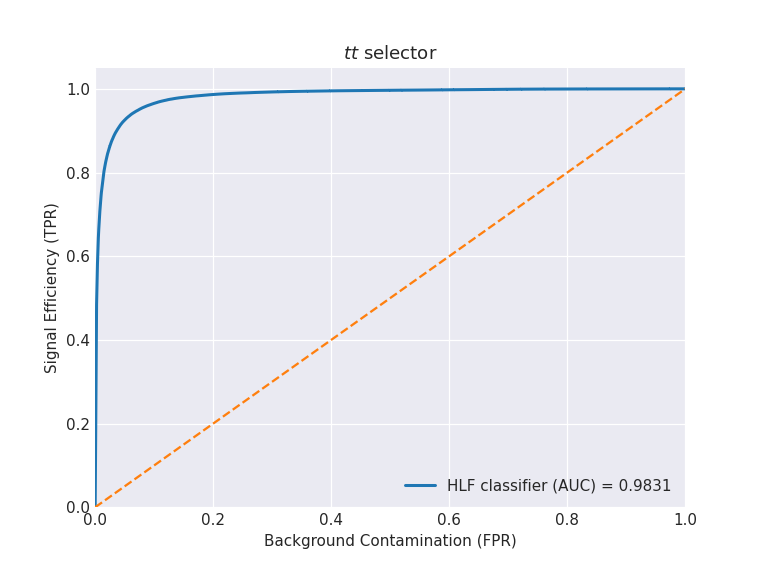

In [21]:
%matplotlib notebook

# Plot roc curve 
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, \
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()